In [7]:
#step 1 import sets of packages criterionically necessary 

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt

In [41]:
# we need to read our csv file to read the price data  and give new column titles to enhance simplicitly, done via pandas package.
data = pd.read_csv(r'C:\Users\andre\OneDrive - University of Essex\Python Data sheet\Portfolio PX_LAST_CSV.csv', header=0)
new_column_names = ['Date', 'NVDA', 'MSFT', 'AAPL', 'AMZN', 'GOOGL', 'META', 'GLD', 'JPM', 'AVGO', 'TSM', 'CITI', 'BAC', 'COST','COF', 'WMT', 'WMC', 'WFC', 'SHELL']
data.columns = new_column_names
data = data.dropna()
data.fillna(0, inplace=True)
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
print (data.columns)

Index(['Date', 'NVDA', 'MSFT', 'AAPL', 'AMZN', 'GOOGL', 'META', 'GLD', 'JPM',
       'AVGO', 'TSM', 'CITI', 'BAC', 'COST', 'COF', 'WMT', 'WMC', 'WFC',
       'SHELL'],
      dtype='object')


In [15]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

print(data.dtypes)

#the purpose of this code is to display results is a sensible way and ensure full conformity with python best priciples (Sensible)

Date     datetime64[ns]
NVDA            float64
MSFT            float64
AAPL            float64
AMZN            float64
GOOGL           float64
META            float64
GLD             float64
JPM             float64
AVGO            float64
TSM             float64
CITI            float64
BAC             float64
COST            float64
COF             float64
WMT             float64
WMC             float64
WFC             float64
SHELL           float64
dtype: object


In [57]:
# Remove any leftover index columns
for col in ['index', 'level_0']:
    if col in data.columns:
        data = data.drop(columns=[col])

rets = np.log(data.drop(columns=['Date']) / data.drop(columns=['Date']).shift(1))

# We need to calculate the log returns, needed for our optimisation code, by using np.log function
# Convert the first column of our csv file to numeric type
data['NVDA'] = pd.to_numeric(data['NVDA'], errors='coerce')
data['MSFT'] = pd.to_numeric(data['MSFT'], errors='coerce')
data['AAPL'] = pd.to_numeric(data['AAPL'], errors='coerce')
data['AMZN'] = pd.to_numeric(data['AMZN'], errors='coerce')
data['GOOGL'] = pd.to_numeric(data['GOOGL'], errors='coerce')
data['META'] = pd.to_numeric(data['META'], errors='coerce')
data['GLD'] = pd.to_numeric(data['GLD'], errors='coerce')
data['JPM'] = pd.to_numeric(data['JPM'], errors='coerce')
data['AVGO'] = pd.to_numeric(data['AVGO'], errors='coerce')
data['TSM'] = pd.to_numeric(data['TSM'], errors='coerce')
data['CITI'] = pd.to_numeric(data['CITI'], errors='coerce')
data['BAC'] = pd.to_numeric(data['BAC'], errors='coerce')
data['COST'] = pd.to_numeric(data['COST'], errors='coerce')
data['COF'] = pd.to_numeric(data['COF'], errors='coerce')
data['WMT'] = pd.to_numeric(data['WMT'], errors='coerce')
data['WMC'] = pd.to_numeric(data['WMC'], errors='coerce')
data['WFC'] = pd.to_numeric(data['WFC'], errors='coerce')
data['SHELL'] = pd.to_numeric(data['SHELL'], errors='coerce')
data.reset_index(inplace=True)  # Set the date column as a normal data column
data.fillna(0, inplace=True)


#finding returns through logarithmic calculation as mentioned earlier 
rets = np.log(data.drop(columns=['Date', 'index']) / data.drop(columns=['Date', 'index']).shift(1))

# we need to convert daily returns to annualized returns (We shall stipualte the axiom that there's 252 trading days per year)
rets.mean() * 252
cov_matrix = np.cov(rets, rowvar=False)

In [59]:
print(rets.mean)

<bound method DataFrame.mean of          NVDA      MSFT      AAPL      AMZN     GOOGL      META       GLD  \
0         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1   -0.003509  0.020829  0.004379  0.004166 -0.006094  0.004623 -0.002588   
2   -0.109470 -0.058231 -0.019234 -0.033753 -0.043614 -0.017933  0.050531   
3    0.089948  0.133912  0.079059  0.085236  0.114915  0.073077  0.097574   
4    0.062520  0.035980  0.016854  0.019085  0.042150  0.025954  0.010227   
..        ...       ...       ...       ...       ...       ...       ...   
777 -0.027909  0.029458 -0.000960  0.002599  0.004570  0.026199  0.000306   
778 -0.007101 -0.020248 -0.029591  0.006284 -0.032839  0.024855 -0.120302   
779  0.028874 -0.001973 -0.015236 -0.003802  0.091526 -0.001031 -0.027564   
780  0.006135  0.021448 -0.001507 -0.004894  0.039265  0.008957 -0.016547   
781 -0.038181 -0.040393 -0.005236  0.003673 -0.018597 -0.022023 -0.016427   

          JPM      AVGO       TSM      CITI

In [61]:
#Define the risk free rate
# This value determination was reached utilising AVG(3 month treasury yields) over the same time interval.
risk_free_rate = 0.04828

def statistics(weights, rets, risk_free_rate):
    """
    Returns portfolio statistics.

    Parameters
    ==========
    weights : array-like
        Weights for different securities in the portfolio, including the risk-free asset.
    rets : DataFrame
        Daily returns of the assets.
    risk_free_rate : float
        Annual risk-free rate as a decimal.

    Returns
    =======
    pret : float
        Expected portfolio return.
    pvol : float

  Expected portfolio volatility.
    sharpe_ratio : float
        Sharpe ratio using the specified risk-free rate.
    """

    # Separate the risk-free weight from the risky asset weights by making 2 seperate arrays, one including and excluding the risk free weight
    risk_free_weight = weights[-1]
    risky_weights = weights[:-1]

    # Calculate expected portfolio return (annualized), risk free weight is included in the returns
    pret = np.sum(rets.mean() * risky_weights) * 252 + risk_free_weight * risk_free_rate

    # Calculate expected portfolio volatility (annualized), the risk free weight is not included the volatility
    pvol = np.sqrt(np.dot(risky_weights.T, np.dot(rets.cov() * 252, risky_weights)))

    # Calculate Sharpe ratio using the risk-free rate
    sharpe_ratio = (pret - risk_free_rate) / pvol

    return np.array([pret, pvol, sharpe_ratio])

In [63]:
from scipy.optimize import minimize

# number of assets being optimised
n_assets = rets.shape[1]

# our initial guess of weights, assume equal weights. This needs to be done for the optimisation function to proceed
init_weights = np.repeat(1/n_assets, n_assets)

# Setting Weight Constraints, weights cant be below 0 or greater than 1 and all weights must add upto 1
bounds = tuple((0, 1) for asset in range(n_assets))
total_weights_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

# Define the function, maximize the Sharpe ratio.
def neg_sharpe_ratio(weights, rets, risk_free_rate):
    stats = statistics(np.append(weights, [1 - sum(weights)]), rets, risk_free_rate)
    return -stats[2]  # Minimizing the negative Sharpe ratio is equivalent to maximizing the Sharpe ratio.

# Solving the optimization Problem
optimized = minimize(neg_sharpe_ratio, init_weights, args=(rets, risk_free_rate), method='SLSQP', bounds=bounds, constraints=total_weights_constraint)

# Optimal weighting of our assets
opt_weights = optimized.x


# Cdisplauing the key Portfolio Statistics
portfolio_stats = statistics(np.append(opt_weights, [1 - sum(opt_weights)]), rets, risk_free_rate)
print(f"Optimal weighting: {opt_weights}")
print(f"Expected annualized rate of return: {portfolio_stats[0]:.2%}")
print(f"Expected annualized volatility: {portfolio_stats[1]:.2%}")
print(f"Sharpe ratio: {portfolio_stats[2]:.2f}")

# Calculating the covariance matrix
cov_matrix = rets.cov() * 252
print("\nCovariance matrix:")
print(cov_matrix)

Optimal weighting: [6.63191738e-17 1.16281330e-01 1.01181870e-16 3.55963048e-16
 2.80902583e-16 1.36024378e-16 1.17883173e-01 4.88902683e-01
 9.91716267e-02 1.14024153e-02 5.98833472e-17 2.52936138e-17
 7.91546920e-17 3.69615817e-17 3.18139639e-16 1.66358771e-01
 4.58903481e-17 7.84785090e-17]
Expected annualized rate of return: 37.89%
Expected annualized volatility: 14.01%
Sharpe ratio: 2.36

Covariance matrix:
           NVDA      MSFT      AAPL      AMZN     GOOGL      META       GLD  \
NVDA   0.252451  0.048264  0.021100  0.026891  0.037766  0.031656  0.035241   
MSFT   0.048264  0.250197  0.067243  0.055050  0.081403  0.065130  0.088679   
AAPL   0.021100  0.067243  0.055017  0.033012  0.048602  0.038334  0.053487   
AMZN   0.026891  0.055050  0.033012  0.068712  0.042437  0.039004  0.043741   
GOOGL  0.037766  0.081403  0.048602  0.042437  0.104803  0.056823  0.075802   
META   0.031656  0.065130  0.038334  0.039004  0.056823  0.089288  0.057853   
GLD    0.035241  0.088679  0.05

In [65]:
opt_weights = np.array(opt_weights) #take the optimal weighs output as the input in array form
opt_weights_pct = opt_weights / opt_weights.sum() * 100 # convert to % form

print("Optimal weighting:")
for i, weight in enumerate(opt_weights_pct):
    print(f"{i+1}. {weight:.2f}%")

Optimal weighting:
1. 0.00%
2. 11.63%
3. 0.00%
4. 0.00%
5. 0.00%
6. 0.00%
7. 11.79%
8. 48.89%
9. 9.92%
10. 1.14%
11. 0.00%
12. 0.00%
13. 0.00%
14. 0.00%
15. 0.00%
16. 16.64%
17. 0.00%
18. 0.00%


Statistics for NVDA:
Statistics of the simulated prices:
Mean: 13.04
Median: 13.03
Standard Deviation: 0.41
Minimum: 11.67
Maximum: 14.65


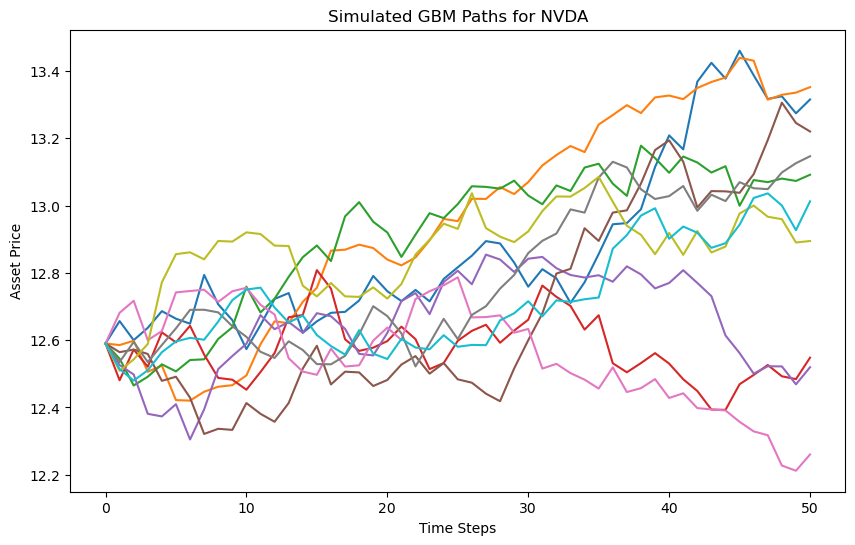

Statistics for MSFT:
Statistics of the simulated prices:
Mean: 205.71
Median: 205.75
Standard Deviation: 6.54
Minimum: 184.08
Maximum: 231.72


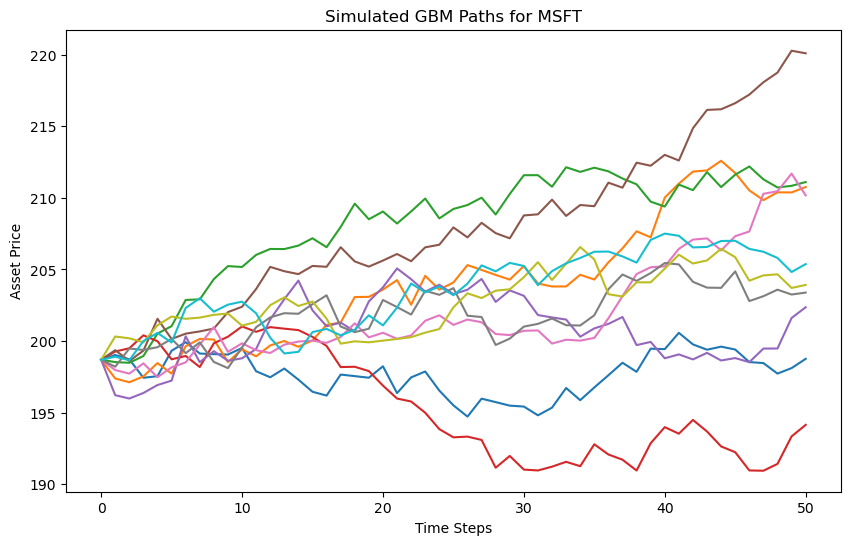

Statistics for AAPL:
Statistics of the simulated prices:
Mean: 532.54
Median: 532.51
Standard Deviation: 7.90
Minimum: 504.55
Maximum: 565.75


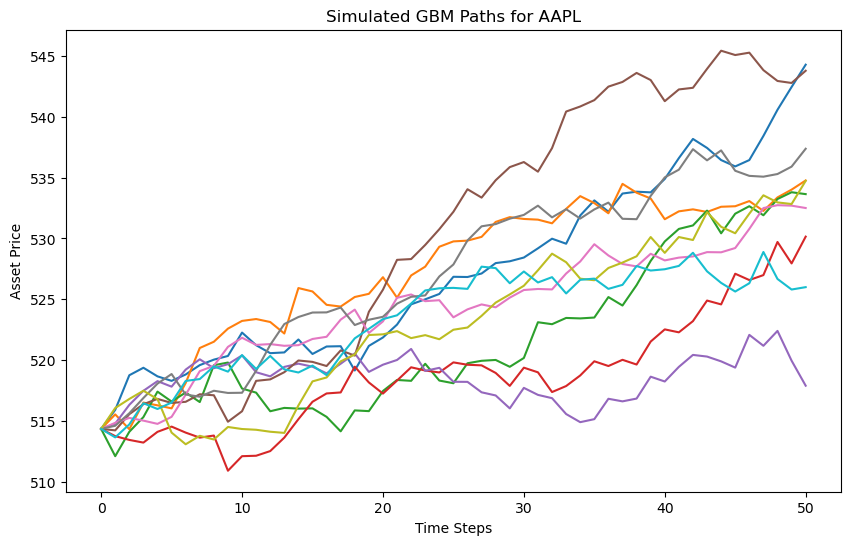

Statistics for AMZN:
Statistics of the simulated prices:
Mean: 279.67
Median: 279.63
Standard Deviation: 4.66
Minimum: 263.54
Maximum: 297.42


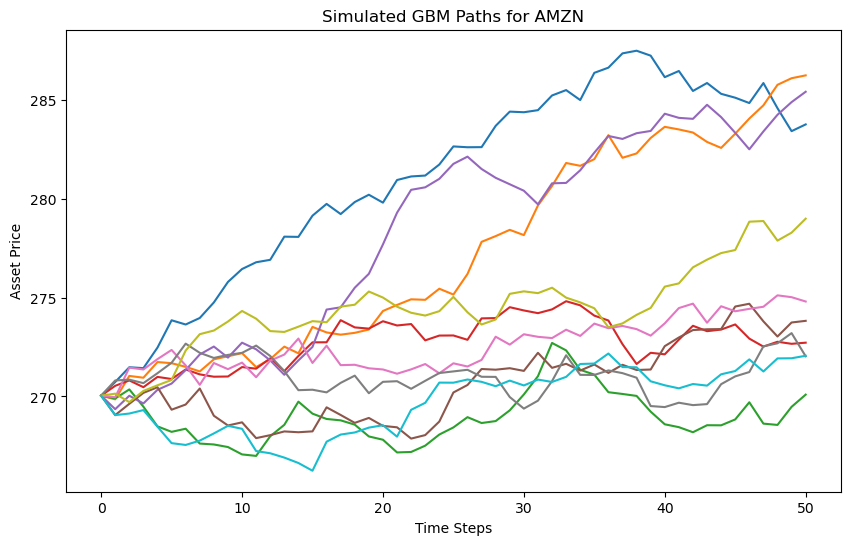

Statistics for GOOGL:
Statistics of the simulated prices:
Mean: 258.23
Median: 258.11
Standard Deviation: 5.23
Minimum: 239.41
Maximum: 283.61


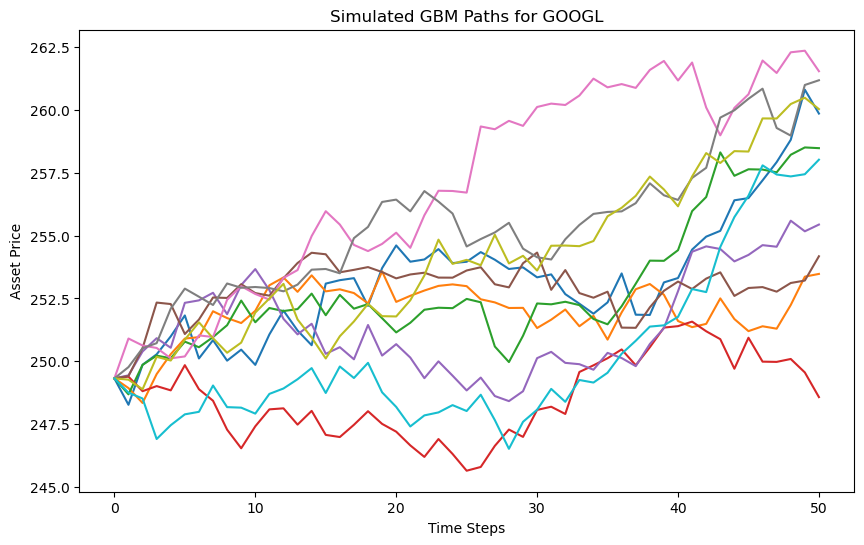

Statistics for META:
Statistics of the simulated prices:
Mean: 287.37
Median: 287.31
Standard Deviation: 5.41
Minimum: 268.54
Maximum: 311.02


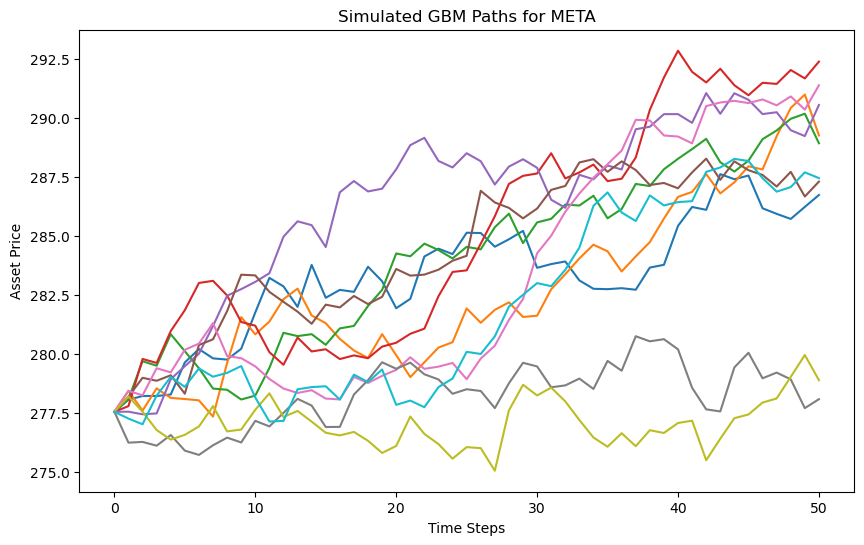

Statistics for GLD:
Statistics of the simulated prices:
Mean: 649.41
Median: 649.23
Standard Deviation: 15.43
Minimum: 597.90
Maximum: 709.42


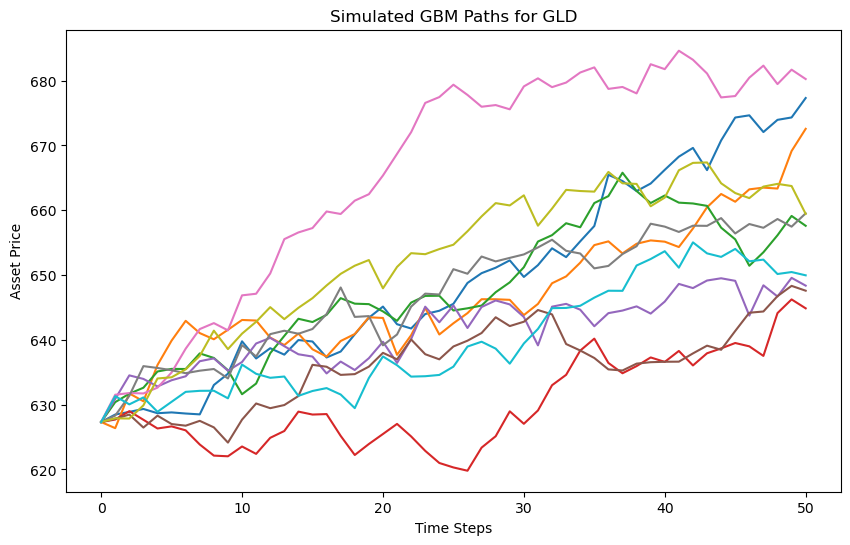

Statistics for JPM:
Statistics of the simulated prices:
Mean: 375.16
Median: 375.14
Standard Deviation: 3.74
Minimum: 360.06
Maximum: 389.19


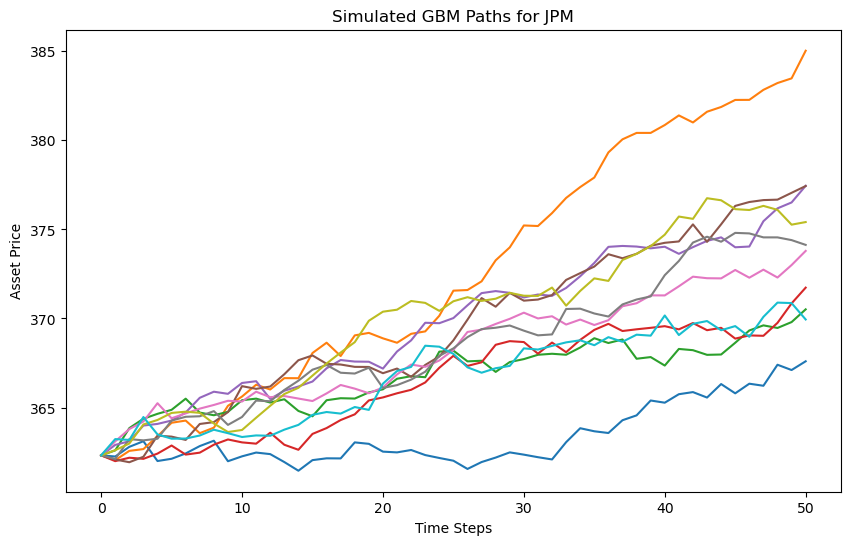

Statistics for AVGO:
Statistics of the simulated prices:
Mean: 320.20
Median: 320.18
Standard Deviation: 4.57
Minimum: 304.43
Maximum: 341.62


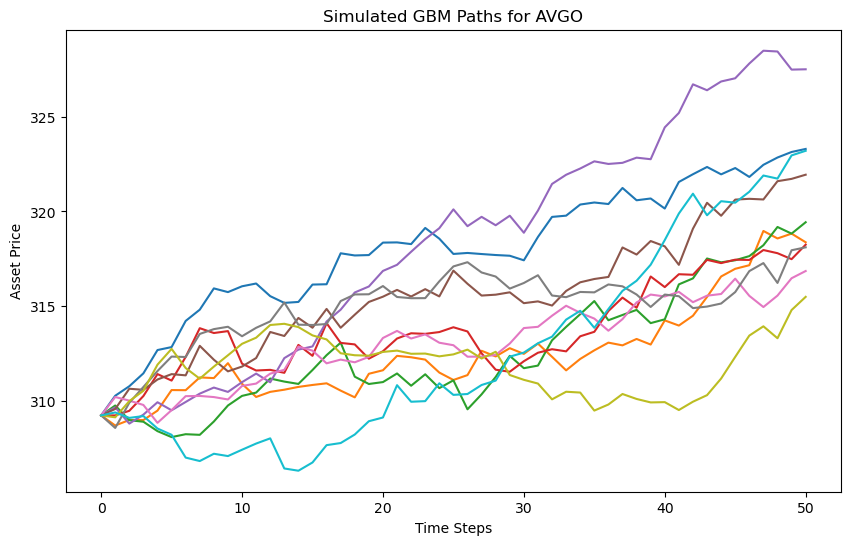

Statistics for TSM:
Statistics of the simulated prices:
Mean: 364.16
Median: 364.17
Standard Deviation: 10.31
Minimum: 326.43
Maximum: 406.56


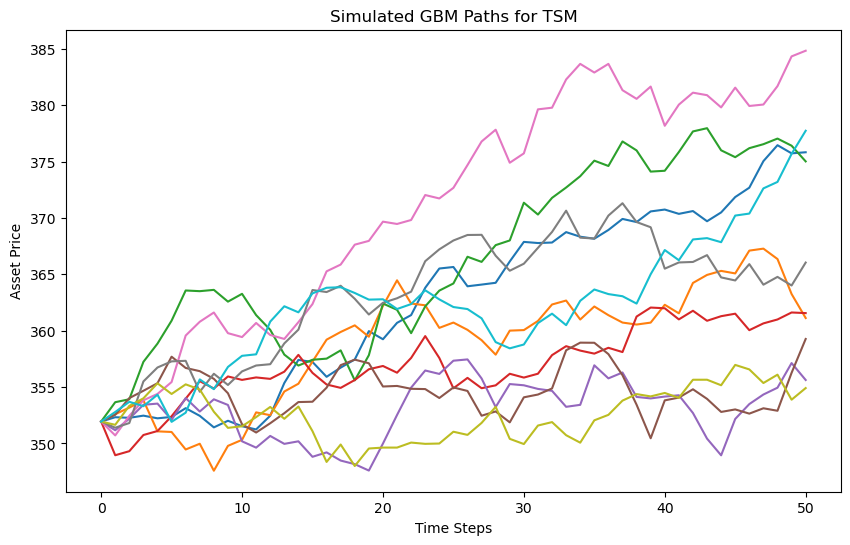

Statistics for CITI:
Statistics of the simulated prices:
Mean: 304.47
Median: 304.40
Standard Deviation: 7.19
Minimum: 278.74
Maximum: 331.47


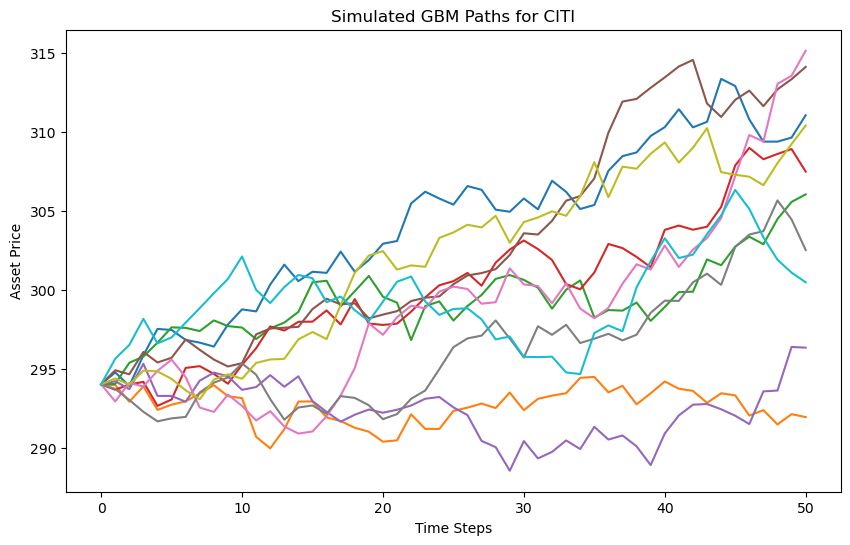

Statistics for BAC:
Statistics of the simulated prices:
Mean: 104.60
Median: 104.58
Standard Deviation: 1.82
Minimum: 97.52
Maximum: 112.66


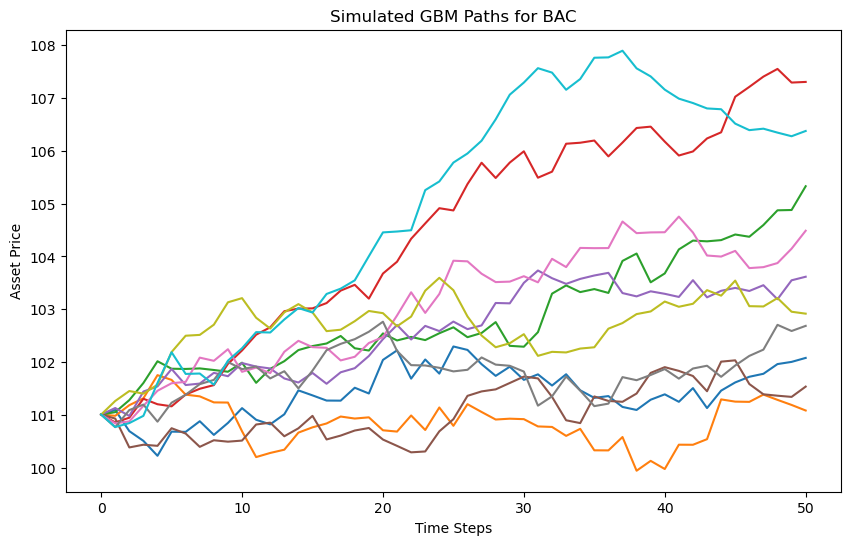

Statistics for COST:
Statistics of the simulated prices:
Mean: 55.43
Median: 55.43
Standard Deviation: 0.89
Minimum: 52.12
Maximum: 58.86


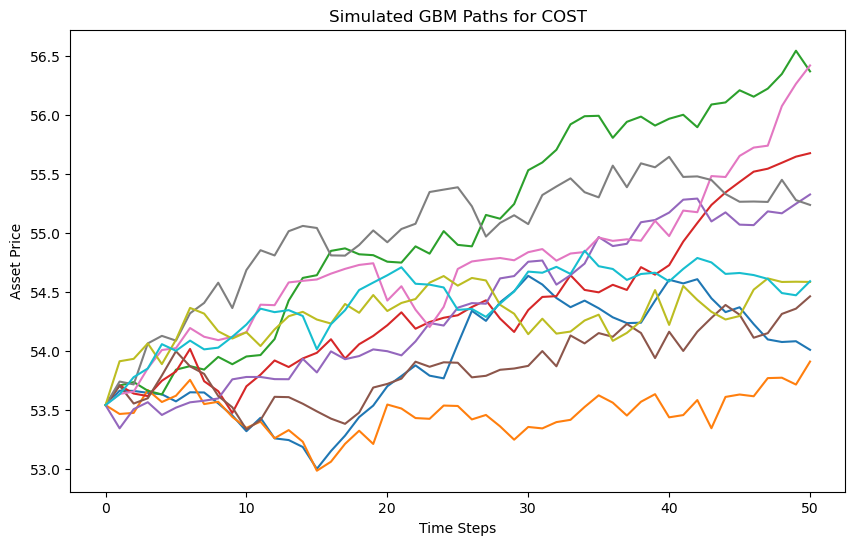

Statistics for COF:
Statistics of the simulated prices:
Mean: 974.11
Median: 974.12
Standard Deviation: 12.42
Minimum: 928.85
Maximum: 1025.35


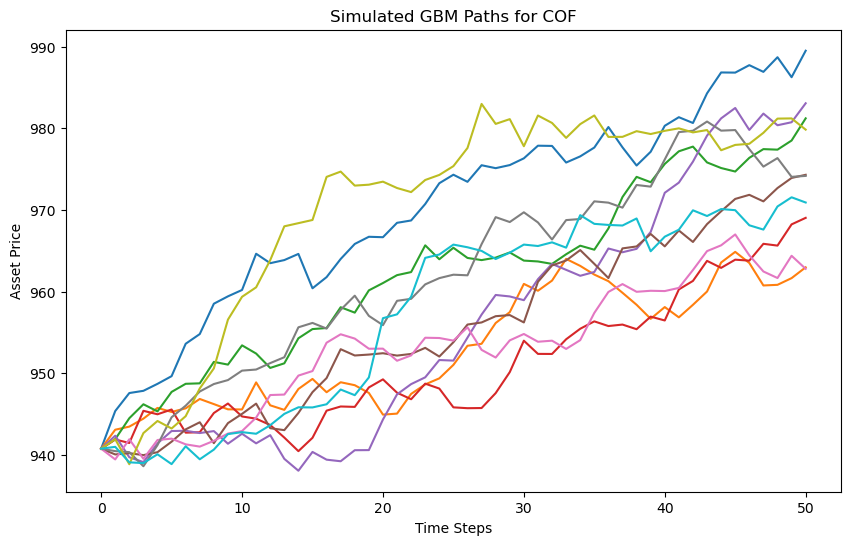

Statistics for WMT:
Statistics of the simulated prices:
Mean: 228.59
Median: 228.56
Standard Deviation: 4.81
Minimum: 210.43
Maximum: 247.85


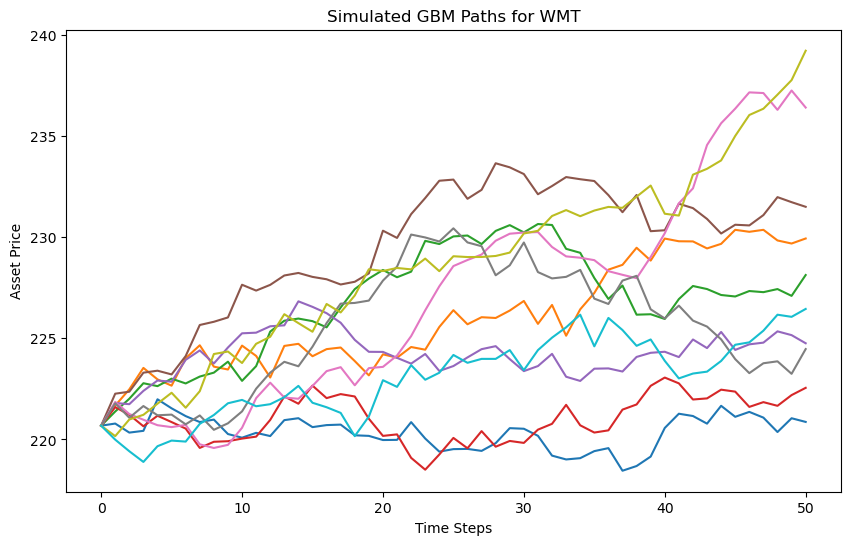

Statistics for WMC:
Statistics of the simulated prices:
Mean: 105.91
Median: 105.90
Standard Deviation: 1.31
Minimum: 100.82
Maximum: 112.86


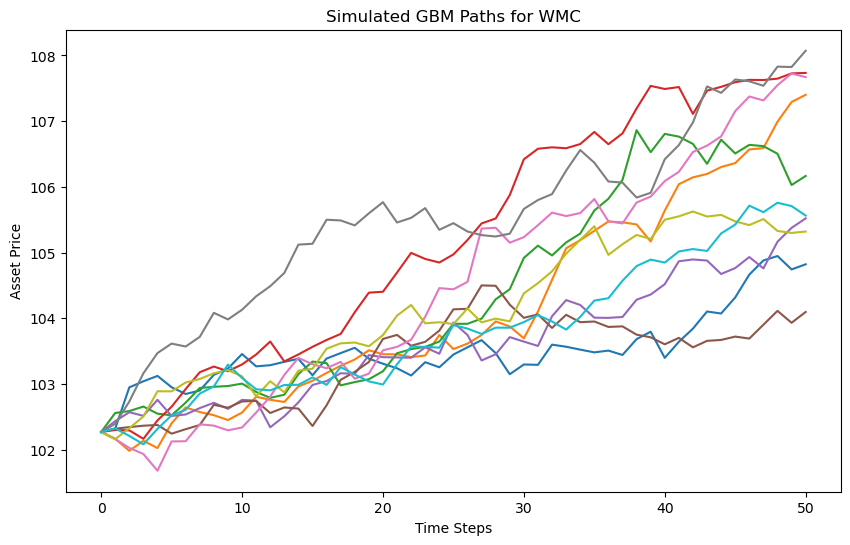

Statistics for WFC:
Statistics of the simulated prices:
Mean: 90.23
Median: 90.20
Standard Deviation: 1.61
Minimum: 84.41
Maximum: 96.00


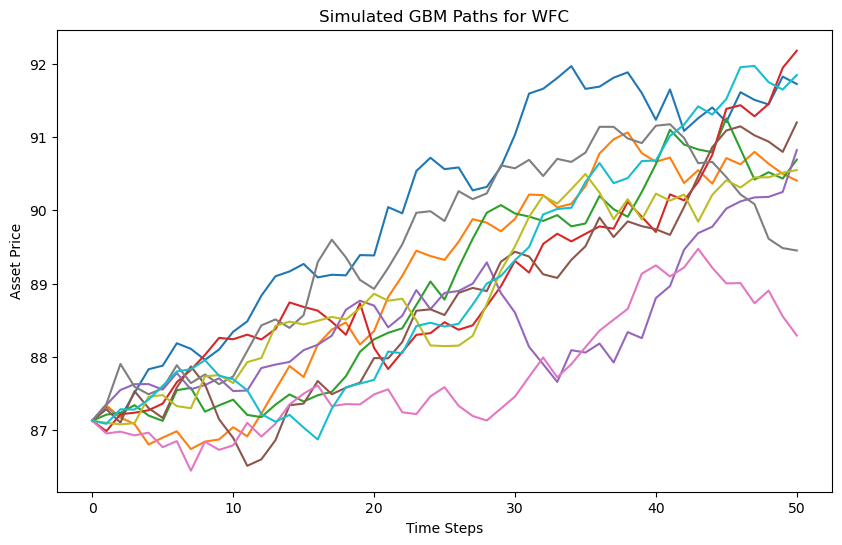

Statistics for SHELL:
Statistics of the simulated prices:
Mean: 2938.92
Median: 2938.04
Standard Deviation: 38.16
Minimum: 2803.60
Maximum: 3085.47


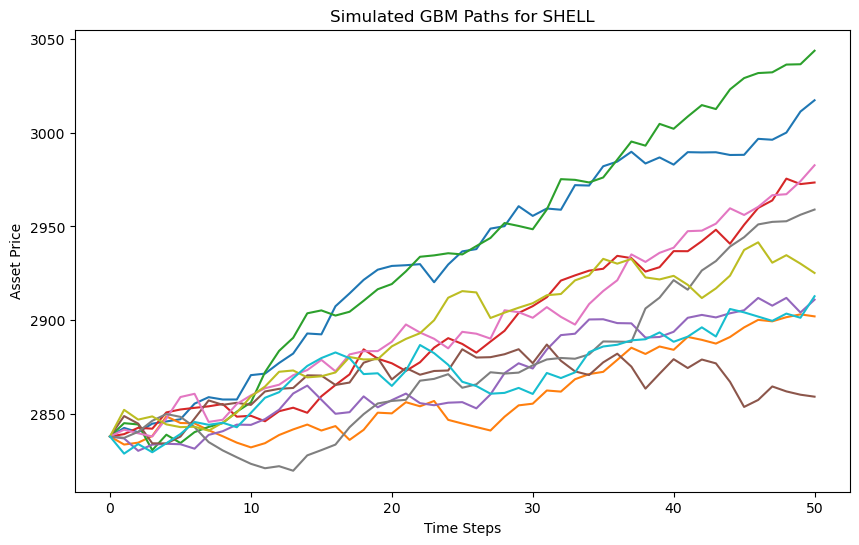

In [67]:
import numpy as np
import pandas as pd

# GBM simulation function
def simulate_gbm(S0, T, r, sigma, I, M=50): #r: The risk-free rate, representing the time value of money.
    dt = T / M  # Length of time interval
    S = np.zeros((M + 1, I))  # Array to store the simulation results
    S[0] = S0  # Set initial value, S0: The initial stock price or portfolio value at time zero.

    for t in range(1, M + 1):
        z = np.random.standard_normal(I)  # Random numbers for simulation
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
    return S

# Function to print statistics of simulation results
def print_statistics(array):
    print("Statistics of the simulated prices:")
    print(f"Mean: {np.mean(array):.2f}")
    print(f"Median: {np.median(array):.2f}")
    print(f"Standard Deviation: {np.std(array):.2f}")
    print(f"Minimum: {np.min(array):.2f}")
    print(f"Maximum: {np.max(array):.2f}")

# Function to plot simulated GBM paths
def plot_gbm_simulation(simulation, asset_name, num_paths=10):
    """
    Plots simulated GBM paths for an asset.

    Parameters:
    simulation : numpy.ndarray
        Array of simulated asset price paths
    asset_name : str
        Name of the asset
    num_paths : int
        Number of paths to plot
    """
    plt.figure(figsize=(10, 6))
    for i in range(num_paths):
        plt.plot(simulation[:, i], lw=1.5)
    plt.title(f'Simulated GBM Paths for {asset_name}')
    plt.xlabel('Time Steps')
    plt.ylabel('Asset Price')
    plt.show()
    


# Number of simulations and time steps
I = 10000  # Number of simulations, I: The number of simulation iterations or paths.
M = 50  # Number of time steps, M: The number of time intervals for the simulation, defaulting to 50 if not provided.
T = 1.0  # Time horizon (1 year), T: The total time horizon for the simulation.

# Risk-free rate from your code
risk_free_rate = 0.035  # Make sure this is the annualized rate

# Dictionary to store the GBM simulations for each asset
gbm_simulations = {}

# Loop through each asset in the portfolio
for asset in rets.columns:
    S0 = data[asset].iloc[-1]  # Last known price for the asset is used for s0
    sigma = np.sqrt(rets[asset].var())  # sigma: Estimate of volatility using variance of the asset's returns
    gbm_simulations[asset] = simulate_gbm(S0, T, risk_free_rate, sigma, I, M) 
#simulates the future stock prices or portfolio values using the Geometric Brownian Motion model, which is a stochastic process. 

# Print statistics for the final simulated prices of each asset
for asset, simulation in gbm_simulations.items():
    print(f"Statistics for {asset}:")
    print_statistics(simulation[-1])
    plot_gbm_simulation(simulation, asset)

Index(['Date', 'NVDA', 'MSFT', 'AAPL', 'AMZN', 'GOOGL', 'META', 'GLD', 'JPM',
       'AVGO', 'TSM', 'CITI', 'BAC', 'COST', 'COF', 'WMT', 'WMC', 'WFC',
       'SHELL'],
      dtype='object')
Number of assets in 'data': 18
Number of weights in 'opt_weights': 18


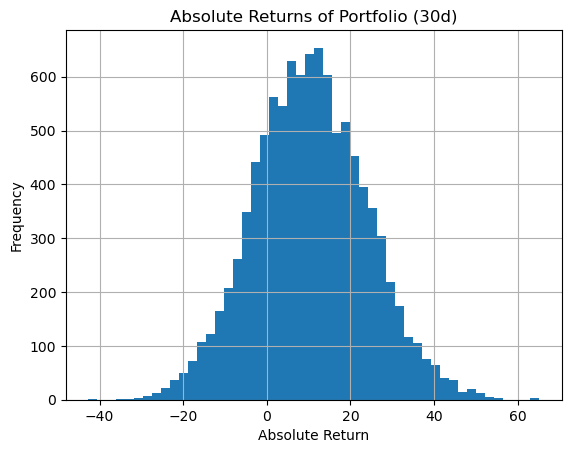

Confidence Level    Value-at-Risk
---------------------------------
           99.99           35.667
           99.90           28.325
           99.00           20.411
           97.50           15.750
           95.00           11.608
           90.00            6.557


In [71]:
import pandas as pd
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt

# Read the price data CSV file and give new column titles
data = pd.read_csv(r'C:\Users\andre\OneDrive - University of Essex\Python Data sheet\Portfolio PX_LAST_CSV.csv', header=0)
new_column_names = ['Date', 'NVDA', 'MSFT', 'AAPL', 'AMZN', 'GOOGL', 'META', 'GLD', 'JPM', 'AVGO', 'TSM', 'CITI', 'BAC', 'COST','COF', 'WMT', 'WMC', 'WFC', 'SHELL']
data.columns = new_column_names
data = data.dropna()
data.fillna(0, inplace=True)
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
print (data.columns)


opt_weights = opt_weights = optimized.x  

# Check the number of assets and weights
num_assets = len(new_column_names) - 1  # Exclude 'Date' column
num_weights = len(opt_weights)

print(f"Number of assets in 'data': {num_assets}")
print(f"Number of weights in 'opt_weights': {num_weights}")

# Ensure that 'opt_weights' has the correct length
if num_assets == num_weights:
    # Proceed with the calculation
    S0 = np.sum(data.iloc[-1, 1:] * opt_weights)  # Initial investment, differet to BGM excluding 'Date' column
    #  s0 is calculated as the sum of the last known prices of each asset multiplied by their respective weights in the portfolio.
    #The code for S0 is designed to establish the starting value of the portfolio before any market movements or returns are factored in.
else:
    print("The number of weights does not match the number of assets. Please check 'data' and 'opt_weights'.")



# Calculate key portfolio statistics
portfolio_stats = statistics(np.append(opt_weights, [1 - sum(opt_weights)]), rets, risk_free_rate) #calling our statistics function array and its stored values
r = portfolio_stats[0]  # Expected portfolio return (pret), we are assuming volatility isnt fixed
sigma = portfolio_stats[1]  # Expected portfolio volatility (pvol)

# Time horizon for VaR calculation (30 days), since all our portfolio statistics are annualised we need to divide over a year to get the time horizon
T = 30 / 365.

# Number of simulations
I = 10000

# Simulate GBM for the portfolio and calculate portfolio end prices
portfolio_end_prices = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * np.random.standard_normal(I))

# Sort the simulated portfolio returns
R_gbm = np.sort(portfolio_end_prices - S0)

# Plot histogram of the simulated portfolio returns
plt.hist(R_gbm, bins=50)
plt.xlabel('Absolute Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.title('Absolute Returns of Portfolio (30d)')
plt.show()

# Confidence levels for VaR calculation
percs = [0.01, 0.1, 1., 2.5, 5.0, 10.0]

# Calculate VaR at different confidence levels
var = scs.scoreatpercentile(R_gbm, percs)

# Print the VaR results
print("%16s %16s" % ('Confidence Level', 'Value-at-Risk'))
print(33 * "-")
for pair in zip(percs, var):
    print("%16.2f %16.3f" % (100 - pair[0], -pair[1]))

In [73]:
# Check for NaN values
if rets.isna().any().any():
    # Handle NaN values, for example, by filling them with zeros
    rets.fillna(0, inplace=True)

# Check for infinite values
if not np.all(np.isfinite(rets)):
    # Handle inf values, for example, by replacing them with a large finite number
    rets.replace([np.inf, -np.inf], np.finfo(np.float64).max, inplace=True)
# without thise section my garch code wouldnt function, better ceaning of data essentially in my csv file with replacing all NaN and infinite values

In [75]:
!pip install arch
import numpy as np
from arch import arch_model

# Define the GARCH volatility function
def garch_volatility(returns):
    try:
        # Fit the GARCH model
        returns = returns * 100
        model = arch_model(returns, vol='Garch', p=1, q=1) # we are using the default garch(1,1) which the earlier equation illustrates
        model_fit = model.fit(disp='off')
        
        # Get the last day's forecast of the variance
        forecast = model_fit.forecast(horizon=1)
        var = forecast.variance.values[-1, :]
        
        # Annualize the volatility
        garch_vol = np.sqrt(var * 252)/ 100
        return garch_vol
    except Exception as e:
        print(f"An error occurred in garch_volatility: {e}")
        # Return a default or previous volatility value or handle as appropriate
        return None

# Define the risk-free rate
risk_free_rate = 0.035

def statistics(weights, rets, risk_free_rate):
    # Separate the risk-free weight from the risky asset weights
    risk_free_weight = weights[-1]
    risky_weights = weights[:-1]
    
    # Calculate expected portfolio return (annualized)
    pret = np.sum(rets.mean() * risky_weights) * 252 + risk_free_weight * risk_free_rate #pret is the same, so is essentially everything else par pvol
    
    # Calculate expected portfolio volatility using GARCH
    pvol = garch_volatility(rets.dot(risky_weights))
    if pvol is None:
        # Handle the case where garch_volatility failed and returned None
        pvol = 0  # Or use a default/previous volatility value
    
    # Calculate Sharpe ratio using the risk-free rate
    # Protect against division by zero if pvol is zero
    sharpe_ratio = (pret - risk_free_rate) / pvol if pvol != 0 else 0
    
    # Convert pret, pvol, and sharpe_ratio to scalars if they are not already
    pret = np.array(pret).item()
    pvol = np.array(pvol).item()
    sharpe_ratio = np.array(sharpe_ratio).item()

    return np.array([pret, pvol, sharpe_ratio])

In [77]:
import numpy as np
from arch import arch_model

# Define the GARCH volatility function
def garch_volatility(returns):
    try:
        # Fit the GARCH model
        returns = returns * 100
        model = arch_model(returns, vol='Garch', p=1, q=1) # we are using the default garch(1,1) which the earlier equation illustrates
        model_fit = model.fit(disp='off')
        
        # Get the last day's forecast of the variance
        forecast = model_fit.forecast(horizon=1)
        var = forecast.variance.values[-1, :]
        
        # Annualize the volatility
        garch_vol = np.sqrt(var * 252)/ 100
        return garch_vol
    except Exception as e:
        print(f"An error occurred in garch_volatility: {e}")
        # Return a default or previous volatility value or handle as appropriate
        return None

# Define the risk-free rate
risk_free_rate = 0.035

def statistics(weights, rets, risk_free_rate):
    # Separate the risk-free weight from the risky asset weights
    risk_free_weight = weights[-1]
    risky_weights = weights[:-1]
    
    # Calculate expected portfolio return (annualized)
    pret = np.sum(rets.mean() * risky_weights) * 252 + risk_free_weight * risk_free_rate #pret is the same, so is essentially everything else par pvol
    
    # Calculate expected portfolio volatility using GARCH
    pvol = garch_volatility(rets.dot(risky_weights))
    if pvol is None:
        # Handle the case where garch_volatility failed and returned None
        pvol = 0  # Or use a default/previous volatility value
    
    # Calculate Sharpe ratio using the risk-free rate
    # Protect against division by zero if pvol is zero
    sharpe_ratio = (pret - risk_free_rate) / pvol if pvol != 0 else 0
    
    # Convert pret, pvol, and sharpe_ratio to scalars if they are not already
    pret = np.array(pret).item()
    pvol = np.array(pvol).item()
    sharpe_ratio = np.array(sharpe_ratio).item()

    return np.array([pret, pvol, sharpe_ratio])

In [79]:
from scipy.optimize import minimize

# Assets number
n_assets = rets.shape[1]

# Initial weights, assumed equal weights
init_weights = np.repeat(1/n_assets, n_assets)

# Setting Weight Constraints
bounds = tuple((0, 1) for asset in range(n_assets))
total_weights_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

# Define the function, maximize the Sharpe ratio.
def neg_sharpe_ratio(weights, rets, risk_free_rate):
    stats = statistics(np.append(weights, [1 - sum(weights)]), rets, risk_free_rate)
    return -stats[2]  # Minimizing the negative Sharpe ratio is equivalent to maximizing the Sharpe ratio.

# Solving Optimization Problems
optimized = minimize(neg_sharpe_ratio, init_weights, args=(rets, risk_free_rate), method='SLSQP', bounds=bounds, constraints=total_weights_constraint)

# Optimal weighting
opt_weights = optimized.x


# Calculating Portfolio Statistics
portfolio_stats = statistics(np.append(opt_weights, [1 - sum(opt_weights)]), rets, risk_free_rate)
print(f"Optimal weighting: {opt_weights}")
print(f"Expected annualized rate of return: {portfolio_stats[0]:.2%}")
print(f"Expected annualized volatility: {portfolio_stats[1]:.2%}")
print(f"Sharpe ratio: {portfolio_stats[2]:.2f}")

# Calculating covariance matrix
cov_matrix = rets.cov() * 252
print("\nCovariance matrix:")
print(cov_matrix)

Optimal weighting: [6.64001925e-03 1.93909906e-01 9.66242027e-04 5.91538000e-02
 3.73628872e-02 7.91038256e-03 2.29855596e-05 1.01099317e-01
 3.61859831e-02 3.96295862e-02 7.96761350e-07 1.24978019e-02
 5.98121990e-03 7.36874954e-03 5.15258992e-05 4.78887505e-01
 3.05125947e-03 9.28003500e-03]
Expected annualized rate of return: 38.21%
Expected annualized volatility: 13.10%
Sharpe ratio: 2.65

Covariance matrix:
           NVDA      MSFT      AAPL      AMZN     GOOGL      META       GLD  \
NVDA   0.252129  0.048204  0.021073  0.026857  0.037719  0.031616  0.035197   
MSFT   0.048204  0.249880  0.067158  0.054981  0.081300  0.065049  0.088568   
AAPL   0.021073  0.067158  0.054947  0.032970  0.048540  0.038286  0.053419   
AMZN   0.026857  0.054981  0.032970  0.068625  0.042383  0.038954  0.043686   
GOOGL  0.037719  0.081300  0.048540  0.042383  0.104670  0.056751  0.075706   
META   0.031616  0.065049  0.038286  0.038954  0.056751  0.089175  0.057780   
GLD    0.035197  0.088568  0.05

In [81]:
opt_weights = np.array(opt_weights)
opt_weights_pct = opt_weights / opt_weights.sum() * 100

print("Optimal weighting:")
for i, weight in enumerate(opt_weights_pct):
    print(f"{i+1}. {weight:.2f}%")

Optimal weighting:
1. 0.66%
2. 19.39%
3. 0.10%
4. 5.92%
5. 3.74%
6. 0.79%
7. 0.00%
8. 10.11%
9. 3.62%
10. 3.96%
11. 0.00%
12. 1.25%
13. 0.60%
14. 0.74%
15. 0.01%
16. 47.89%
17. 0.31%
18. 0.93%


Statistics for NVDA:
Statistics of the simulated prices:
Mean: 13.04
Median: 13.03
Standard Deviation: 0.42
Minimum: 11.66
Maximum: 14.91


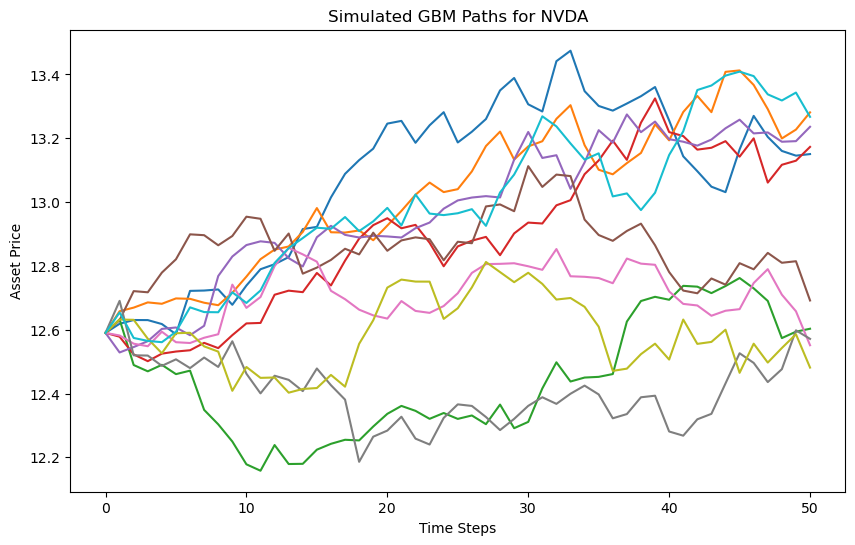

Statistics for MSFT:
Statistics of the simulated prices:
Mean: 205.86
Median: 205.60
Standard Deviation: 6.48
Minimum: 183.93
Maximum: 230.28


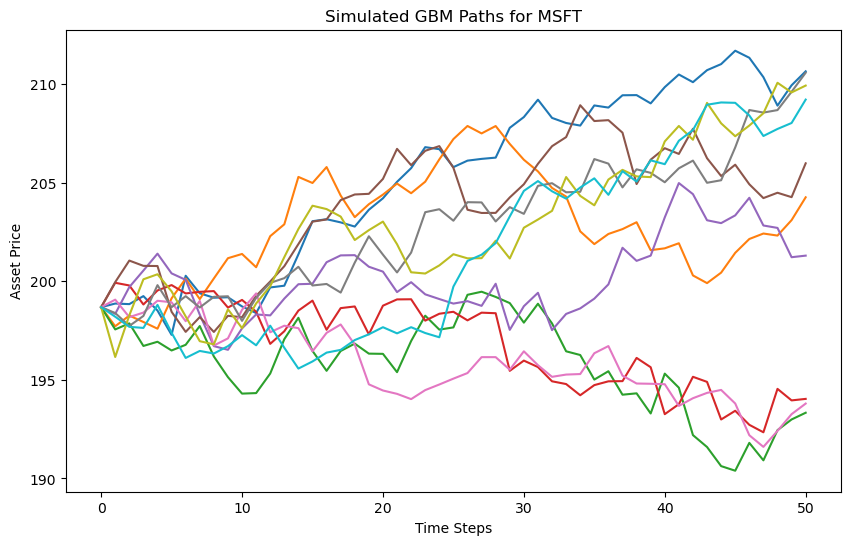

Statistics for AAPL:
Statistics of the simulated prices:
Mean: 532.54
Median: 532.51
Standard Deviation: 7.79
Minimum: 502.68
Maximum: 561.84


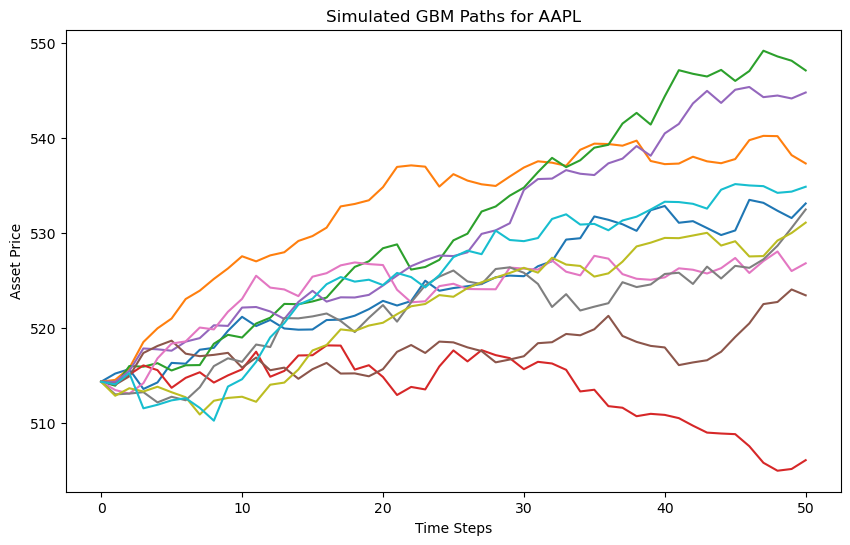

Statistics for AMZN:
Statistics of the simulated prices:
Mean: 279.72
Median: 279.66
Standard Deviation: 4.59
Minimum: 264.34
Maximum: 295.94


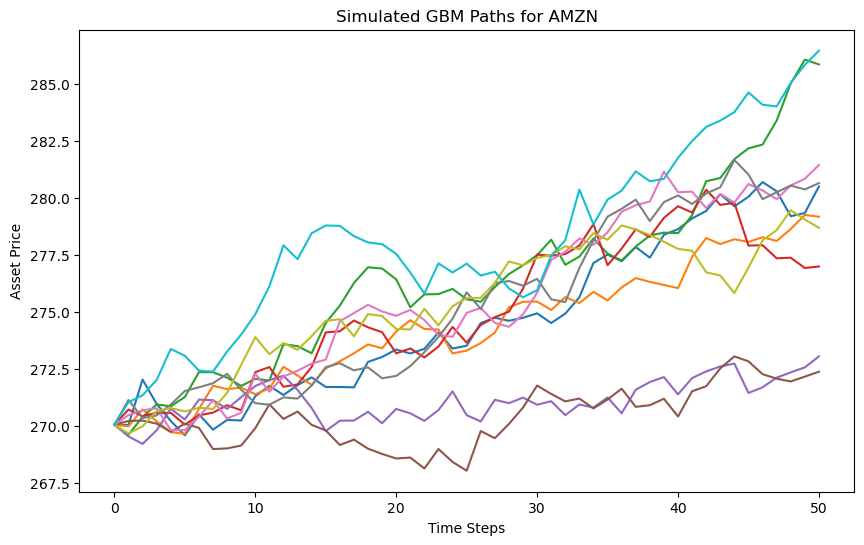

Statistics for GOOGL:
Statistics of the simulated prices:
Mean: 258.14
Median: 258.12
Standard Deviation: 5.22
Minimum: 239.05
Maximum: 280.26


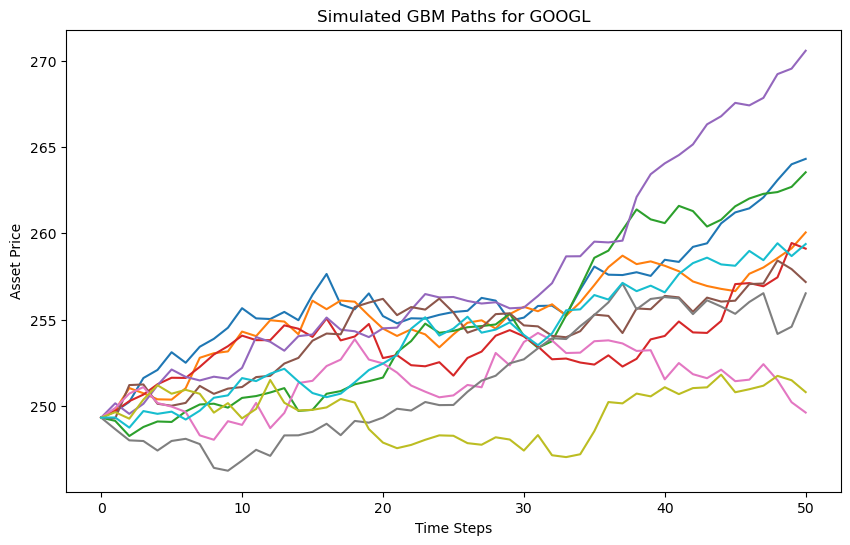

Statistics for META:
Statistics of the simulated prices:
Mean: 287.47
Median: 287.42
Standard Deviation: 5.38
Minimum: 268.65
Maximum: 310.16


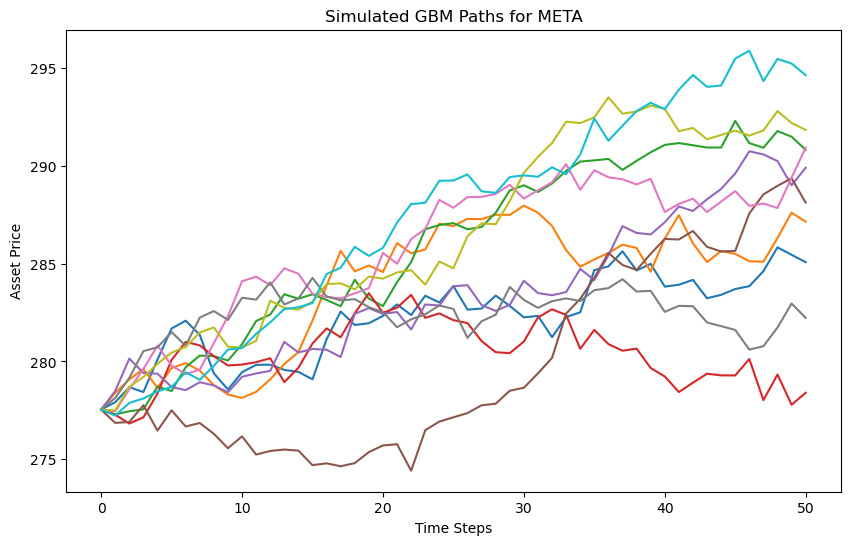

Statistics for GLD:
Statistics of the simulated prices:
Mean: 649.35
Median: 649.10
Standard Deviation: 15.35
Minimum: 591.87
Maximum: 709.56


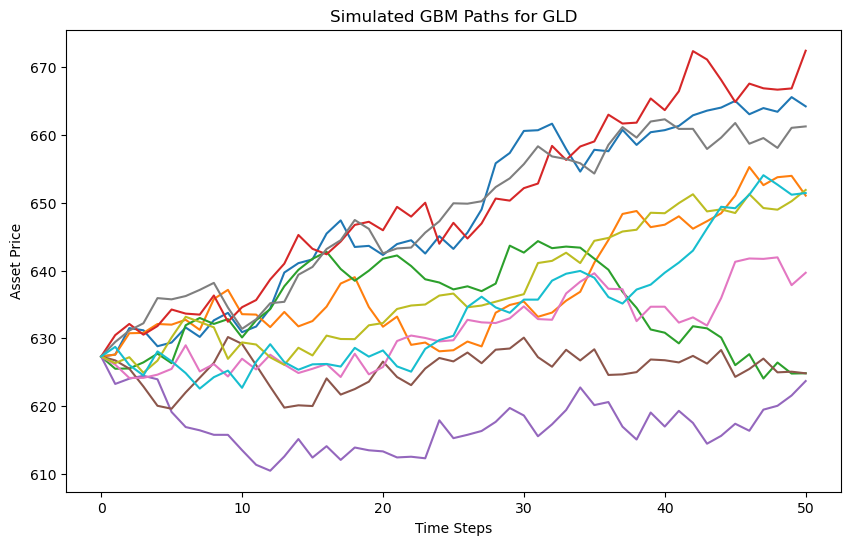

Statistics for JPM:
Statistics of the simulated prices:
Mean: 375.23
Median: 375.27
Standard Deviation: 3.79
Minimum: 359.17
Maximum: 389.14


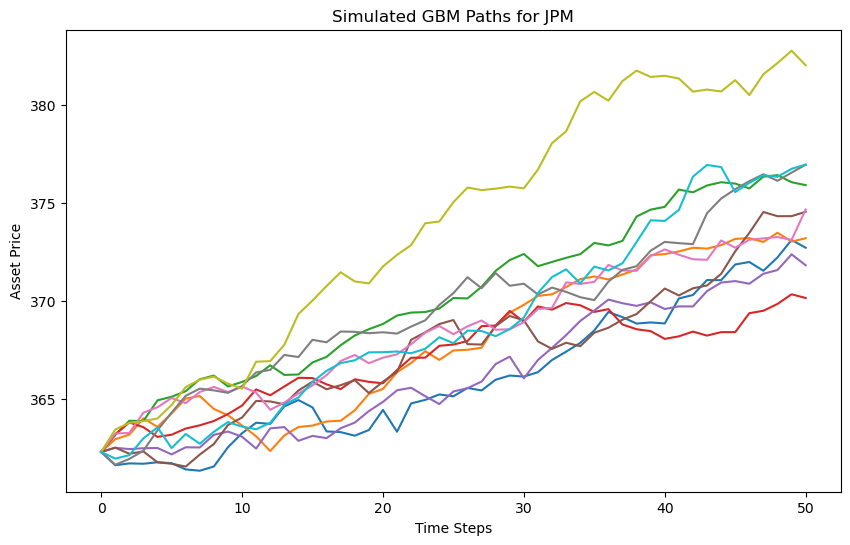

Statistics for AVGO:
Statistics of the simulated prices:
Mean: 320.22
Median: 320.17
Standard Deviation: 4.54
Minimum: 304.55
Maximum: 337.37


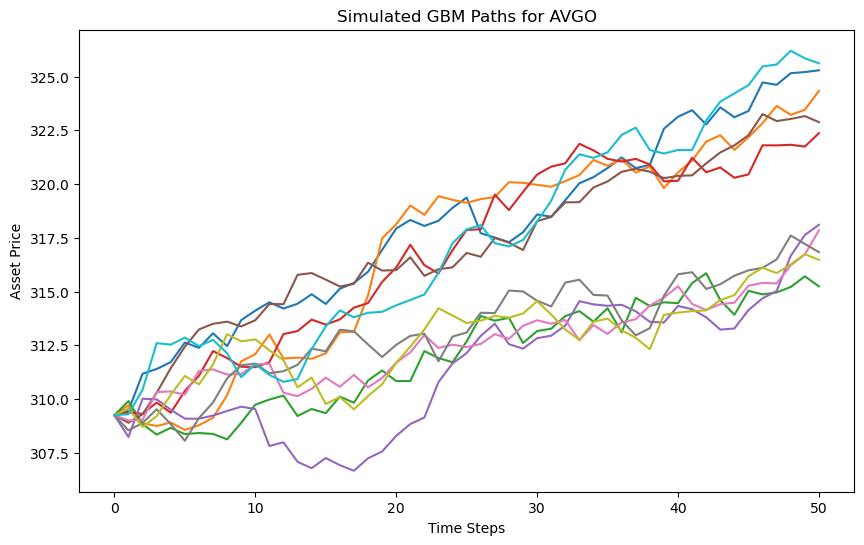

Statistics for TSM:
Statistics of the simulated prices:
Mean: 364.62
Median: 364.48
Standard Deviation: 10.40
Minimum: 330.47
Maximum: 408.69


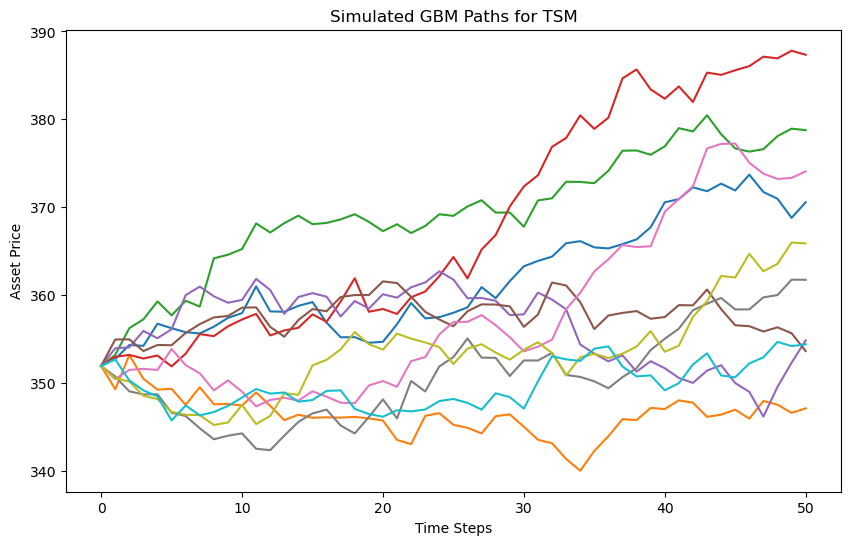

Statistics for CITI:
Statistics of the simulated prices:
Mean: 304.52
Median: 304.45
Standard Deviation: 7.27
Minimum: 277.03
Maximum: 333.62


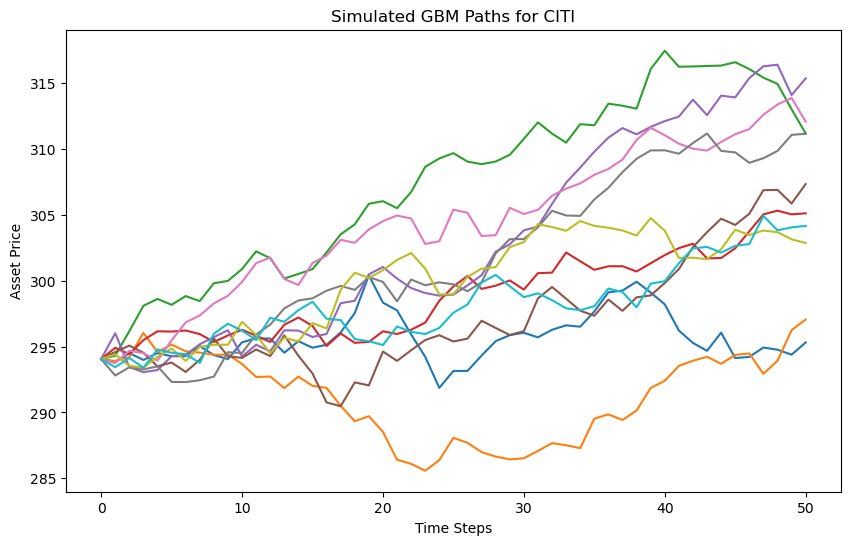

Statistics for BAC:
Statistics of the simulated prices:
Mean: 104.61
Median: 104.60
Standard Deviation: 1.84
Minimum: 98.19
Maximum: 112.34


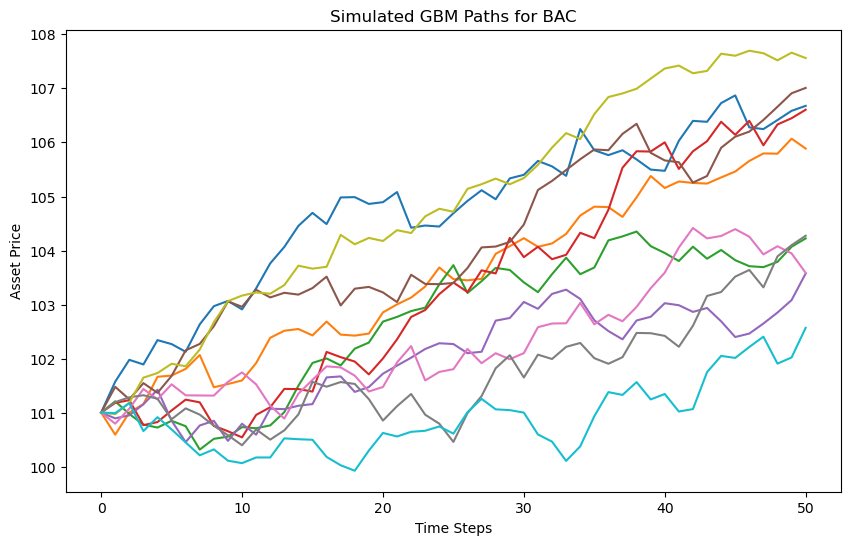

Statistics for COST:
Statistics of the simulated prices:
Mean: 55.45
Median: 55.44
Standard Deviation: 0.89
Minimum: 51.36
Maximum: 59.16


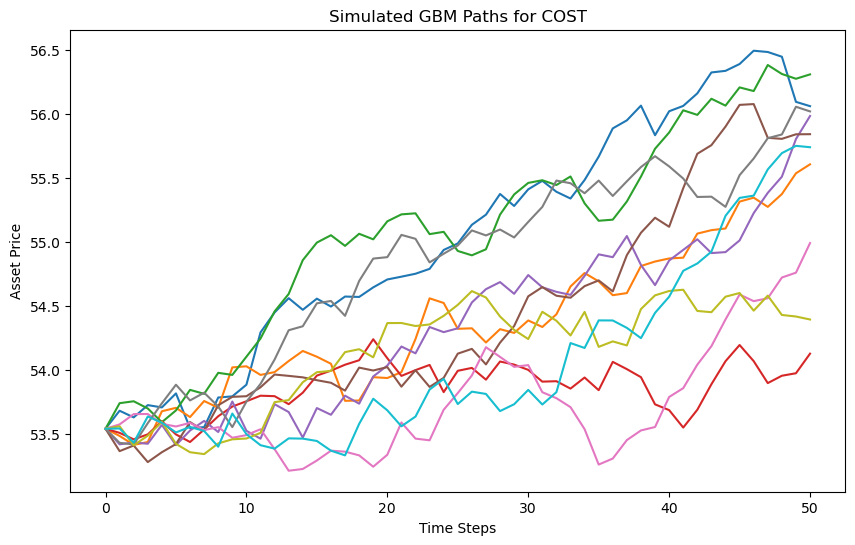

Statistics for COF:
Statistics of the simulated prices:
Mean: 974.07
Median: 974.00
Standard Deviation: 12.25
Minimum: 929.90
Maximum: 1019.79


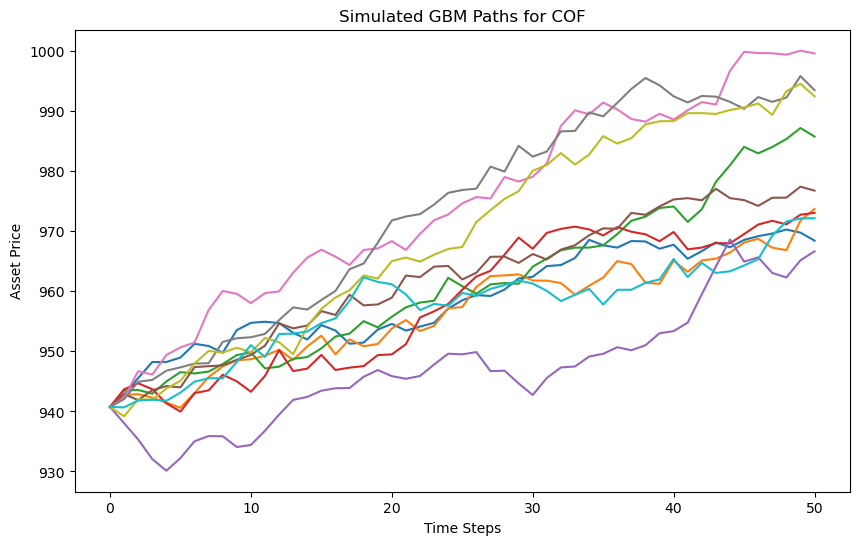

Statistics for WMT:
Statistics of the simulated prices:
Mean: 228.53
Median: 228.55
Standard Deviation: 4.85
Minimum: 209.90
Maximum: 247.10


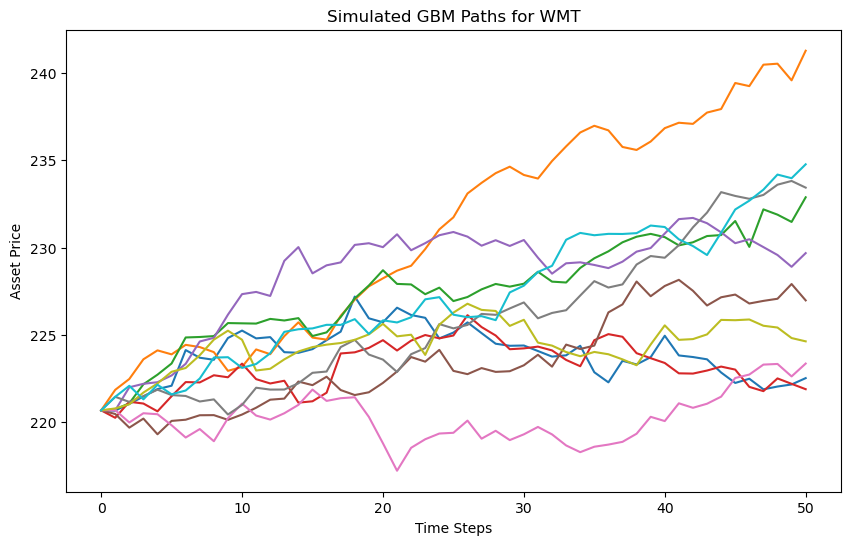

Statistics for WMC:
Statistics of the simulated prices:
Mean: 105.89
Median: 105.87
Standard Deviation: 1.31
Minimum: 100.82
Maximum: 110.82


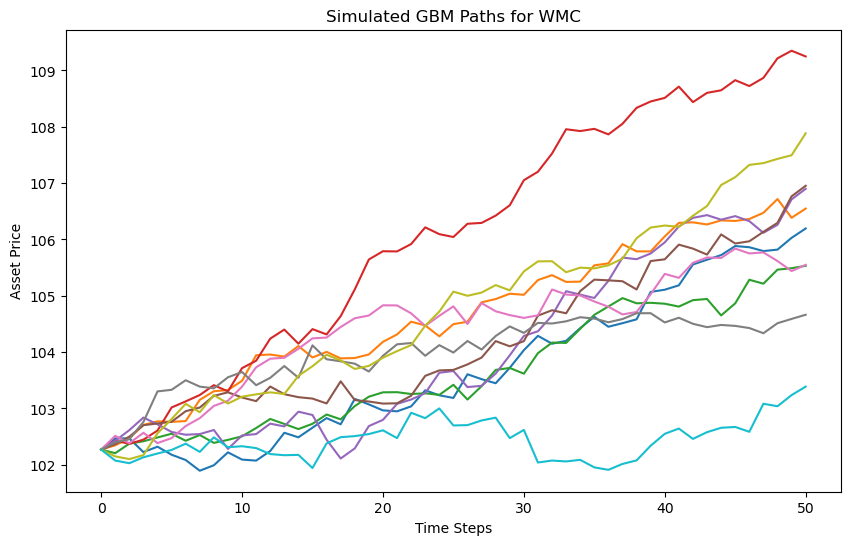

Statistics for WFC:
Statistics of the simulated prices:
Mean: 90.23
Median: 90.23
Standard Deviation: 1.59
Minimum: 84.96
Maximum: 97.25


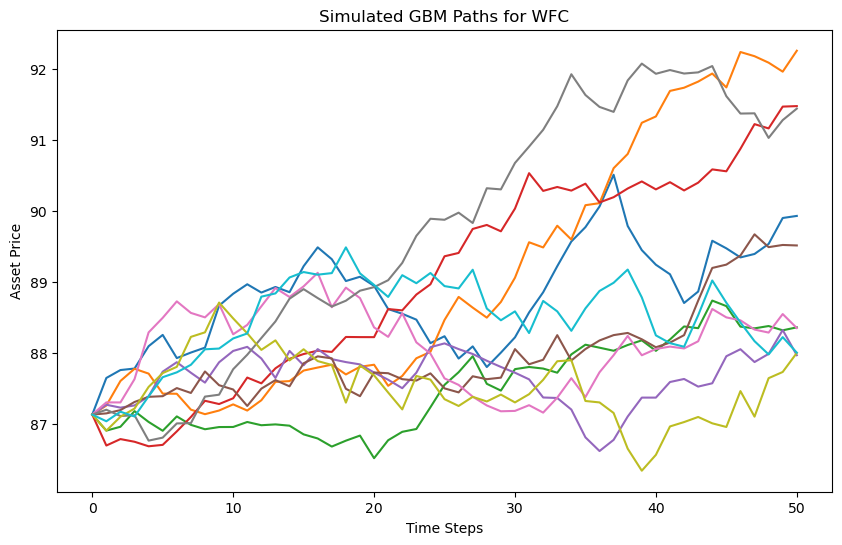

Statistics for SHELL:
Statistics of the simulated prices:
Mean: 2939.24
Median: 2939.01
Standard Deviation: 38.13
Minimum: 2799.78
Maximum: 3107.65


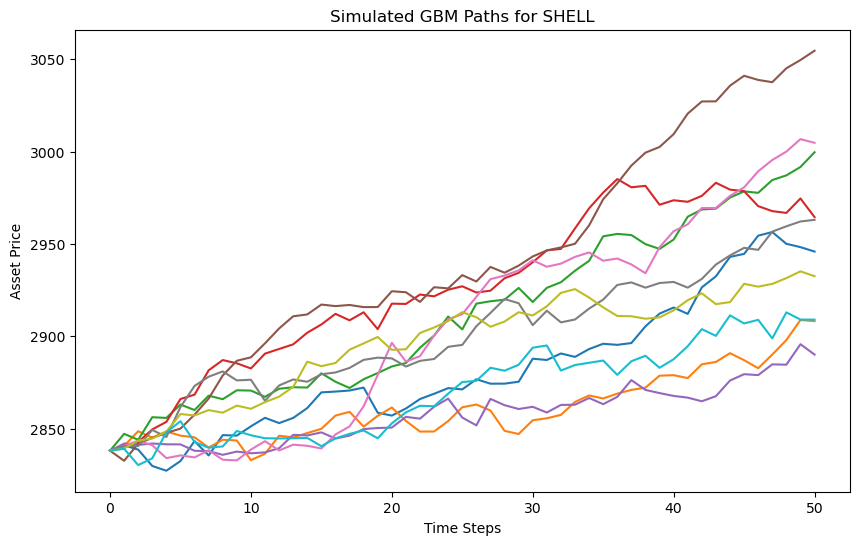

In [83]:
import numpy as np
import pandas as pd

# GBM simulation function
def simulate_gbm(S0, T, r, sigma, I, M=50):
    dt = T / M  # Length of time interval
    S = np.zeros((M + 1, I))  # Array to store the simulation results
    S[0] = S0  # Set initial value

    for t in range(1, M + 1):
        z = np.random.standard_normal(I)  # Random numbers for simulation
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
    return S

# Function to print statistics of simulation results
def print_statistics(array):
    print("Statistics of the simulated prices:")
    print(f"Mean: {np.mean(array):.2f}")
    print(f"Median: {np.median(array):.2f}")
    print(f"Standard Deviation: {np.std(array):.2f}")
    print(f"Minimum: {np.min(array):.2f}")
    print(f"Maximum: {np.max(array):.2f}")

# Function to plot simulated GBM paths
def plot_gbm_simulation(simulation, asset_name, num_paths=10):
    """
    Plots simulated GBM paths for an asset.

    Parameters:
    simulation : numpy.ndarray
        Array of simulated asset price paths
    asset_name : str
        Name of the asset
    num_paths : int
        Number of paths to plot
    """
    plt.figure(figsize=(10, 6))
    for i in range(num_paths):
        plt.plot(simulation[:, i], lw=1.5)
    plt.title(f'Simulated GBM Paths for {asset_name}')
    plt.xlabel('Time Steps')
    plt.ylabel('Asset Price')
    plt.show()
    
# Assume you have the optimized weights from your portfolio optimization
# opt_weights = ...

# Number of simulations and time steps
I = 10000  # Number of simulations
M = 50  # Number of time steps
T = 1.0  # Time horizon (1 year)

# Risk-free rate from your code
risk_free_rate = 0.035  # Make sure this is the annualized rate

# Dictionary to store the GBM simulations for each asset
gbm_simulations = {}

# Loop through each asset in the portfolio
for asset in rets.columns:
    S0 = data[asset].iloc[-1]  # Last known price for the asset
    sigma = np.sqrt(rets[asset].var())  # Estimate volatility using variance of the asset's returns
    gbm_simulations[asset] = simulate_gbm(S0, T, risk_free_rate, sigma, I, M)

# Print statistics for the final simulated prices of each asset
for asset, simulation in gbm_simulations.items():
    print(f"Statistics for {asset}:")
    print_statistics(simulation[-1])
    plot_gbm_simulation(simulation, asset)

Number of assets in 'data': 18
Number of weights in 'opt_weights': 18


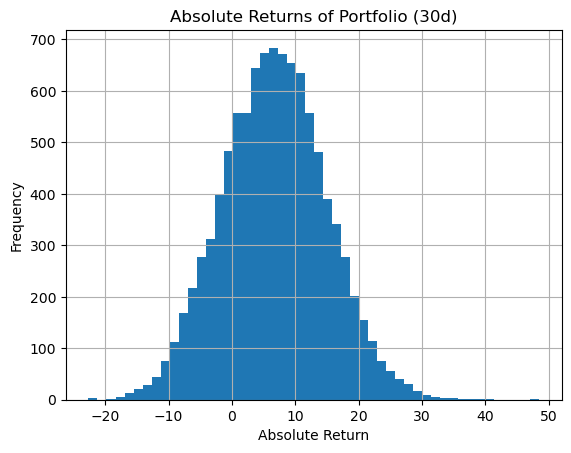

Confidence Level    Value-at-Risk
---------------------------------
           99.99           22.420
           99.90           16.890
           99.00           11.737
           97.50            9.004
           95.00            6.798
           90.00            3.976


In [87]:
import pandas as pd
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt

# Read the price data CSV file and give new column titles
# we need to read our csv file to read the price data  and give new column titles to enhance simplicitly, done via pandas package.
data = pd.read_csv(r'C:\Users\andre\OneDrive - University of Essex\Python Data sheet\Portfolio PX_LAST_CSV.csv', header=0)
new_column_names = ['Date', 'NVDA', 'MSFT', 'AAPL', 'AMZN', 'GOOGL', 'META', 'GLD', 'JPM', 'AVGO', 'TSM', 'CITI', 'BAC', 'COST','COF', 'WMT', 'WMC', 'WFC', 'SHELL']
data.columns = new_column_names
data = data.dropna()
data.fillna(0, inplace=True)
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')

# Assume you have the optimized weights from your portfolio optimization
opt_weights = opt_weights = optimized.x  # Replace with your actual optimized weights

# Check the number of assets and weights
num_assets = len(new_column_names) - 1  # Exclude 'Date' column
num_weights = len(opt_weights)

print(f"Number of assets in 'data': {num_assets}")
print(f"Number of weights in 'opt_weights': {num_weights}")

# Ensure that 'opt_weights' has the correct length
if num_assets == num_weights:
    # Proceed with the calculation
    S0 = np.sum(data.iloc[-1, 1:] * opt_weights)  # Initial investment, excluding 'Date' column
    # ... (rest of your code for VaR calculation)
else:
    print("The number of weights does not match the number of assets. Please check 'data' and 'opt_weights'.")

# Define the statistics function to calculate expected return and volatility
# ... (your statistics function here)

# Calculate key portfolio statistics
portfolio_stats = statistics(np.append(opt_weights, [1 - sum(opt_weights)]), rets, risk_free_rate)
r = portfolio_stats[0]  # Expected portfolio return (pret)
sigma = portfolio_stats[1]  # Expected portfolio volatility (pvol)

# Time horizon for VaR calculation (30 days)
T = 30 / 365.

# Number of simulations
I = 10000

# Simulate GBM for the portfolio and calculate portfolio end prices
portfolio_end_prices = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * np.random.standard_normal(I))

# Sort the simulated portfolio returns
R_gbm = np.sort(portfolio_end_prices - S0)

# Plot histogram of the simulated portfolio returns
plt.hist(R_gbm, bins=50)
plt.xlabel('Absolute Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.title('Absolute Returns of Portfolio (30d)')
plt.show()

# Confidence levels for VaR calculation
percs = [0.01, 0.1, 1., 2.5, 5.0, 10.0]

# Calculate VaR at different confidence levels
var = scs.scoreatpercentile(R_gbm, percs)

# Print the VaR results
print("%16s %16s" % ('Confidence Level', 'Value-at-Risk'))
print(33 * "-")
for pair in zip(percs, var):
    print("%16.2f %16.3f" % (100 - pair[0], -pair[1]))